# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*

# Pakages Import

In [1]:
# !pip install scikit-optimize --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency,ttest_ind
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,roc_auc_score,roc_curve,precision_score, recall_score,f1_score
import keras
from keras.layers import Dense
from keras.models import Sequential

In [3]:
df = pd.read_csv("recipe_site_traffic_2212.csv")
df.head(3)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN


# Validation & EDA

In [4]:
df.describe()

,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


In [5]:
df['high_traffic'].unique()

array(['High', nan], dtype=object)

In [6]:
df.high_traffic = df.high_traffic.fillna('Low')
df['high_traffic'].unique()

array(['High', 'Low'], dtype=object)

In [7]:
df['high_traffic'] = df['high_traffic'].map({
    'High': 1,
    'Low': 0
})

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  947 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 59.3+ KB


In [9]:
miss_cal_rows = df[df['calories'].isna()]
new_df = pd.DataFrame(miss_cal_rows)
for type in ['calories', 'carbohydrate', 'sugar', 'protein']:
    print('No of missing values in ', type, " is: ", new_df[type].isna().count())

No of missing values in  calories  is:  52
No of missing values in  carbohydrate  is:  52
No of missing values in  sugar  is:  52
No of missing values in  protein  is:  52


In [10]:
print("Percent of missing values: ", new_df[type].isna().count()/len(df))

Percent of missing values:  0.054910242872228086


After analyzing the information about the missing values, there are 52 entries (around 5% in total) with missing data for all four types of nutrients.

At first, I wanted to delete the null values, but since we only have about 1,000 features, and we only have 6 features, this is not a good way to handle it.

So I grouped the data together based on categories and servings, and then filled the data according to their statistical characteristics. I think this is reasonable, because similar types of food should have similar food ingredients and nutritional composition.

In [11]:
# Check if the servings' values are consistent
df['servings'].unique()

array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

In [12]:
df['servings'] = df['servings'].replace(
    {
        '4 as a snack': 4, 
        '6 as a snack': 6
    }
)
df['servings'] = df['servings'].astype(int)

In [13]:
# Check if the missing values are in the same category
df[df['calories'].isna()].pivot_table(index=['high_traffic','category'],values='recipe',aggfunc='count')

recipe
high_traffic category              
0            Chicken              3
             Chicken Breast       2
             Dessert              1
             Lunch/Snacks         2
             Meat                 2
             One Dish Meal        3
1            Chicken              2
             Chicken Breast       2
             Dessert              5
             Lunch/Snacks         5
             Meat                 3
             One Dish Meal        1
             Pork                11
             Potato               5
             Vegetable            5

In [14]:
# This means_ will be used for data imputation
means_ = df.pivot_table(index=['category', 'servings'], values=['calories', 'carbohydrate', 'sugar', 'protein'])
means_

calories  carbohydrate    protein      sugar
category       servings                                                
Beverages      1         180.341000     13.237000   0.751500  10.337500
               2         245.478824     21.030000   0.572353  15.809412
               4         162.894706     14.629118   0.551765  16.265294
               6         144.427619     16.586190   0.533333   5.947619
Breakfast      1         401.969615     39.189615  24.025769   4.534231
               2         374.082857     41.820000  12.289048   7.759048
               4         266.214634     40.415122  18.059756   7.748780
               6         330.973889     36.403889   9.681667  11.222778
Chicken        1         419.004000     27.174667  46.293333   4.266667
               2         573.600000     53.863846  55.700769   4.430769
               4         703.353667     26.865333  28.503333   6.745333
               6         387.458182     18.911818  55.783636   6.167273
Chicken Breast 1         611.538000     15.572000  50.032500   5.546500
               2         447.079375     27.456250  63.260000   7.113750
               4         469.466154     24.067692  42.990000   4.460256
               6         689.400526     19.102105  63.881579   4.241053
Dessert        1         317.120625     50.169375   7.025625  40.714375
               2         256.160769     42.809231   5.286154  36.091538
               4         372.850714     73.439643   4.674643  34.657857
               6         410.706000     43.521000   6.574500  31.077500
Lunch/Snacks   1         591.517059     39.027059  14.185294   4.788824
               2         473.288000     53.782000  35.627333   4.946000
               4         461.155806     39.235161  19.692903   6.130968
               6         411.296842     43.412632  11.687368   4.720526
Meat           1         659.651538     29.419231  39.724615   4.977692
               2         636.413077     22.022308  39.659231   9.224615
               4         571.235588     20.028235  40.876765   5.442647
               6         498.903571     20.722143  40.435714   4.323571
One Dish Meal  1         770.896923     47.323846  34.583077   4.555385
               2         534.366818     29.879091  35.137727   5.586364
               4         570.316667     61.967619  40.120000   7.255238
               6         458.604545     72.892727  31.085455   6.209091
Pork           1         716.210000     32.642222  50.250000   7.626667
               2         565.615625     30.924375  26.233750   7.676875
               4         575.858485     29.088182  40.221818   8.795758
               6         764.641333     20.072000  66.528000   7.013333
Potato         1         616.695000     68.992143  10.041429   4.266429
               2         312.203000     69.528000   5.857000   2.970000
               4         432.185000     58.071111  10.277500   3.703333
               6         346.359565     46.728261   6.196522   3.735652
Vegetable      1         222.646667     30.360000   3.735000   2.913333
               2         175.022222     20.510000   7.776111   5.108333
               4         247.720000     26.098500   7.794500   4.925750
               6         336.862857     17.979286  10.100714   6.330000

In [15]:
for index, row in df[df['calories'].isna()].iterrows():
    temp_impu = means_.loc[(row['category'], row['servings']), ['calories', 'carbohydrate', 'sugar', 'protein']]
    df.loc[index, ['calories', 'carbohydrate', 'sugar', 'protein']] = temp_impu
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      947 non-null    float64
 2   carbohydrate  947 non-null    float64
 3   sugar         947 non-null    float64
 4   protein       947 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    int64  
 7   high_traffic  947 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 59.3+ KB


5 differnet steps will be implemented to get the insights of data by analysis:

1. Identifying outliers
2. Assessing skewness
3. Examining correlation
4. Investigating association
5. Creating new features

In [16]:
# Identify outliers
def plot_outliers(dataframe):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
    sns.boxplot(x=dataframe['calories'], ax=axs[0,0])
    sns.boxplot(x=dataframe['carbohydrate'], ax=axs[0,1])
    sns.boxplot(x=dataframe['sugar'], ax=axs[1,0])
    sns.boxplot(x=dataframe['protein'], ax=axs[1,1])
    plt.tight_layout()
    plt.show()

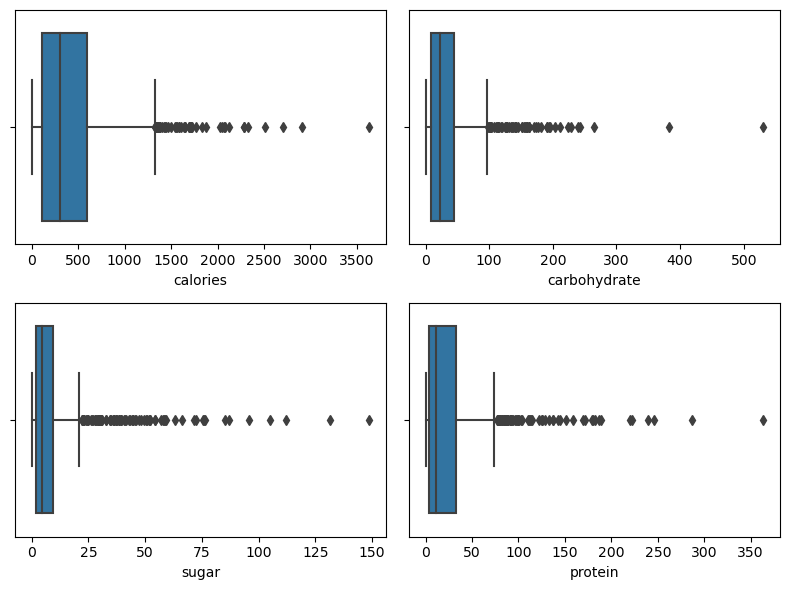

In [17]:
plot_outliers(df)

In [18]:
# Assess skewness
def plot_skewness(dataframe):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
    sns.histplot(data=dataframe, x='calories', kde=True, ax=axs[0,0])
    sns.histplot(data=dataframe, x='carbohydrate', kde=True, ax=axs[0,1])
    sns.histplot(data=dataframe, x='sugar', kde=True, ax=axs[1,0])
    sns.histplot(data=dataframe, x='protein', kde=True, ax=axs[1,1])
    plt.tight_layout()
    plt.show()

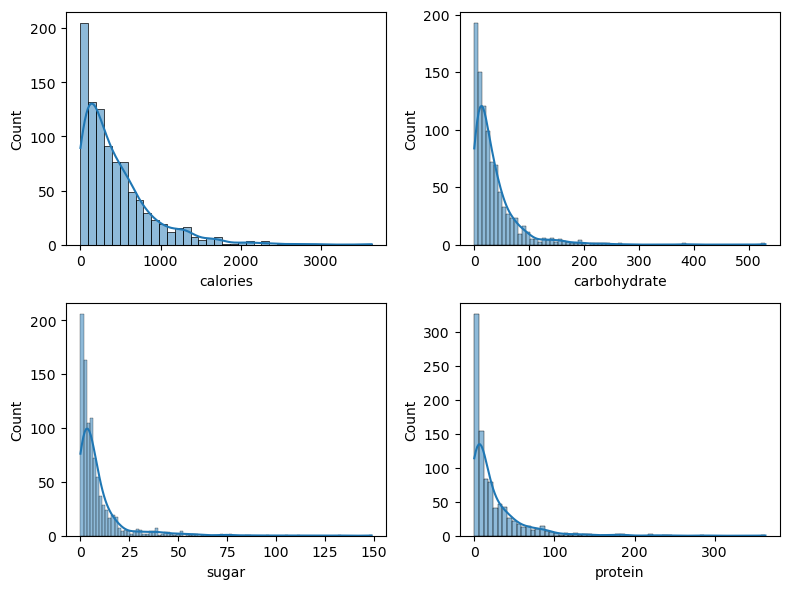

In [19]:
plot_skewness(df)

In [20]:
# Other distribution
def plot_category_distribution(dataframe):
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 10))
    sns.countplot(x='category', data=dataframe, ax=axs[0], orient='v')
    axs[0].set_xlabel('Category')
    axs[0].set_ylabel('Count')
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
    sns.countplot(x='servings', data=dataframe, ax=axs[1], orient='v')
    axs[1].set_xlabel('Servings')
    axs[1].set_ylabel('Count')
    sns.countplot(x='high_traffic', data=dataframe, ax=axs[2], orient='v')
    axs[2].set_xlabel('High Traffic')
    axs[2].set_ylabel('Count')
    plt.tight_layout()
    plt.show()

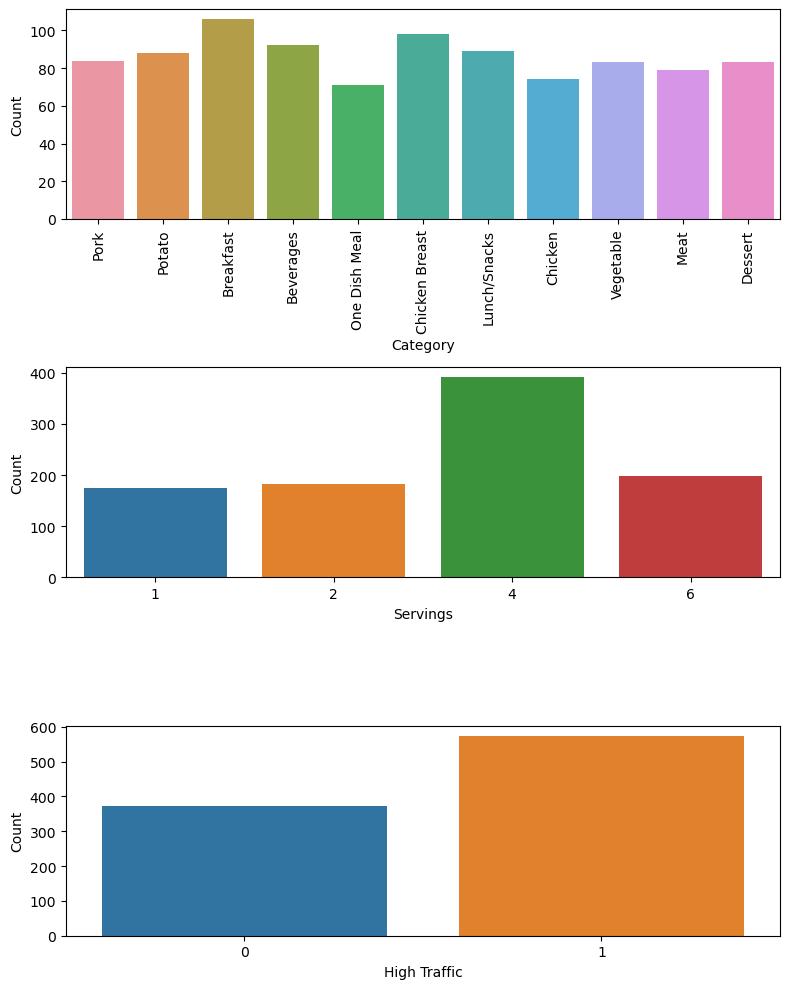

In [21]:
plot_category_distribution(df)

By using distplot to visualize the distribution of calories, carbohydrates, sugars, and proteins, I found that they were all skewed to the left. By using distplot to visualize the distribution of calories, carbohydrates, sugars, and proteins, I found that they were all skewed to the left. This means that most values are concentrated on the left side of the distribution, while the right side has fewer values. 
 
This information is important because it affects the performance of our model. Left-skewness can cause problems with certain statistical tests and models, such as logistic regression, which assumes normally distributed data. It also shows that there may be outliers in the data that could have a significant impact on the results of our analysis. So, when building your model, it's important to keep this skew in mind and consider using appropriate preprocessing techniques to address it. This means that most values are concentrated on the left side of the distribution, while the right side has fewer values.

In [22]:
# Correlation
corr = df[['calories', 'carbohydrate', 'sugar', 'protein']].corr()
corr

,calories,carbohydrate,sugar,protein
calories,1.000000,-0.031116,-0.099515,0.181506
carbohydrate,-0.031116,1.000000,0.077461,-0.049348
sugar,-0.099515,0.077461,1.000000,-0.104548
protein,0.181506,-0.049348,-0.104548,1.000000


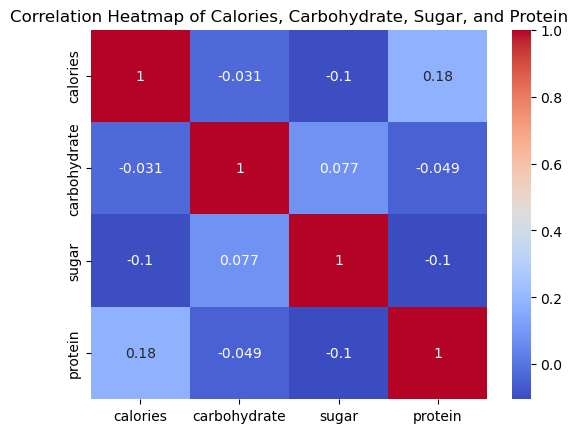

In [23]:
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Calories, Carbohydrate, Sugar, and Protein')
plt.show()

In [24]:
def plot_nutrition_pairplot(df):
    nutritions = ['calories', 'carbohydrate', 'sugar', 'protein']
    sns.set(style='ticks')
    sns.pairplot(df[nutritions + ['category']], hue='category', height=2.5, aspect=1.5, diag_kind='hist', palette='bright')

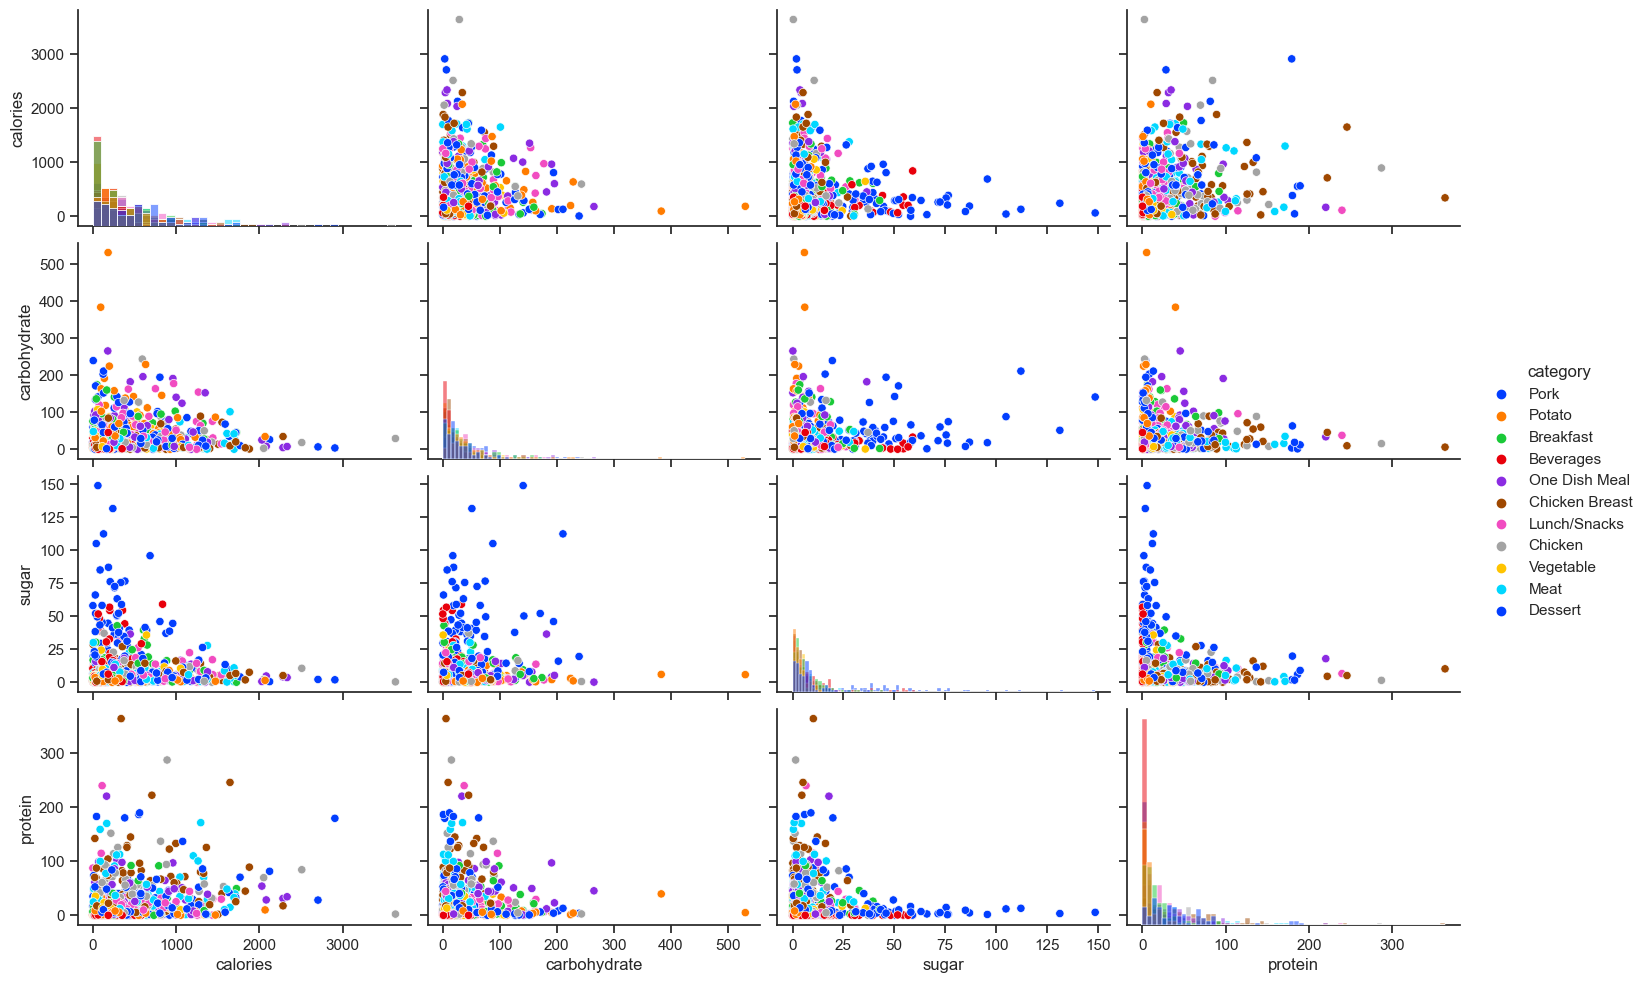

In [25]:
plot_nutrition_pairplot(df)

We can see that the correlation between features is relatively weak, with the relationship between heat and protein having the highest correlation coefficient of 0.18. This indicates that there is no strong linear relationship between any of the features and will not have much impact on the performance of the Parametric models

## Statistical Test

In [27]:
nutritions = ['calories', 'carbohydrate', 'sugar', 'protein']
high_traffic = df['high_traffic']
nutritions_scaled = StandardScaler().fit_transform(df[nutritions])

for nutrition in nutritions:
    nutrition_scaled = nutritions_scaled[:, nutritions.index(nutrition)]
    high_traffic_0 = nutrition_scaled[high_traffic == 0]
    high_traffic_1 = nutrition_scaled[high_traffic == 1]
    t, p = ttest_ind(high_traffic_0, high_traffic_1)
    print(f'{nutrition}: t = {t:.2f}, p = {p:.4f}')

calories: t = -2.29, p = 0.0225
carbohydrate: t = -2.42, p = 0.0156
sugar: t = 2.22, p = 0.0269
protein: t = -1.35, p = 0.1761


Based on the results you provided, the following conclusions can be drawn: 
 
* For ***calories***, ***carbohydrate*** and ***sugar***, they are significantly different when high_traffic is 0 and 1 because their p-values are all less than 0.05
* For ***protein***, they are not significantly different when high_traffic is 0 and 1 because its p-value is greater than 0.05

In [28]:
contingency_table = pd.crosstab(df['category'], df['high_traffic'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p

(320.22296286253834, 8.182067546493786e-63)

In [29]:
contingency_table = pd.crosstab(df['servings'], df['high_traffic'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p

(2.7369889309788054, 0.4339779666711946)

Chi-squared statistic is used to determine the association between two categorical variables. In this case, the variables are "category" and "high_traffic". The obtained Chi2 value of 320.13 indicates a significant association between these two variables. The p-value of 8.55e-63 indicates that the probability of observing such a strong association by chance alone is very low. Therefore, we can conclude that there is a significant relationship between "category" and "high_traffic" in the dataset

# Feature Engineering

During the analysis, I determined that there was a strong association between nutrient composition, category, and high traffic characteristics 
 
I conclude this insight with two things: 

1. Healthy food may play an important role in transportation which is why nutrition has a lot to do with transportation. 
2. The difficulty of recipes may also influence why some categories result in high traffic than others. 

Therefore, two new features are extracted: one indicating whether the recipe is healthy or not, and the other indicating the difficulty level of the recipe. These features will be used to further enhance the predictive power of the model.

In [30]:
df['healthy'] = np.where((df['calories'] <= 400) & (df['carbohydrate'] >= 15) & (df['carbohydrate'] <= 80) & (df['protein'] >= 10)  & (df['sugar'] <= 10), 'Yes', 'No')
df['healthy'] =df.apply(lambda x: "Yes" if x['category']=='Vegetable' else x["healthy"],axis=1)

df[df['healthy']=='Yes'].value_counts(['high_traffic'])

high_traffic
1               142
0                47
dtype: int64

we have 191 healthy recipe out of 944 recipe which means 20% of the recipes are healthy.

the probability of getting a high traffic recipe knowing it's healthy is 0.75 which is a very high percentage. 3 out of 4 healthy recipes produces high traffic

In [31]:
category_points = {'Beverages': 1, 'Breakfast': 1, 'Chicken': 3, 'Chicken Breast': 2, 'Dessert': 4,
                   'Lunch/Snacks': 3, 'Meat': 4, 'One Dish Meal': 3, 'Pork': 4, 'Potato': 1, 'Vegetable': 1}

# Create a dictionary to map servings to difficulty points

# Create a new column "difficulty" by mapping the category and servings to their corresponding points
df['difficulty'] = df['category'].map(category_points) + df['servings']
df[['difficulty','high_traffic']].groupby('difficulty').value_counts()

difficulty  high_traffic
2           0                39
            1                29
3           1                50
            0                39
4           1                40
            0                22
5           1               145
            0               104
6           1                48
            0                39
7           1                96
            0                71
8           1                95
            0                29
9           1                29
            0                16
10          1                42
            0                14
dtype: int64

In [33]:
high_traffic_df = df[df['high_traffic'] == 1]
low_traffic_df = df[df['high_traffic'] == 0]


t, p = ttest_ind(high_traffic_df['difficulty'], low_traffic_df['difficulty'])
print("t-statistic for difficulty: ", t)
print("p-value for difficulty: ", p,'\n')

t-statistic for difficulty:  4.19077188397972
p-value for difficulty:  3.0407526032804283e-05 



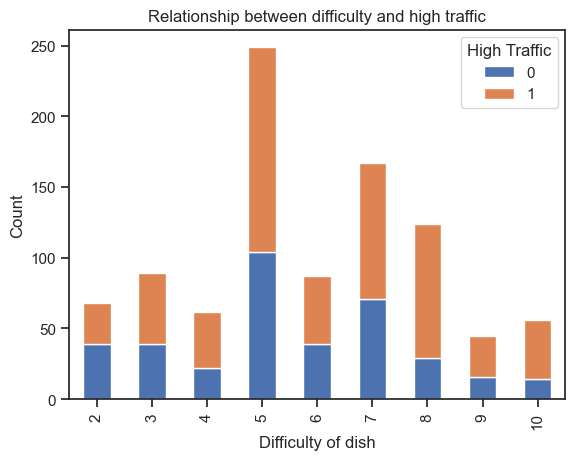

In [45]:
# Create a cross-tabulation
ct = pd.crosstab(df['difficulty'], df['high_traffic'])
ct.plot(kind='bar', stacked=True)

plt.xlabel('Difficulty of dish')
plt.ylabel('Count')
plt.title('Relationship between difficulty and high traffic')
plt.legend(title='High Traffic', loc='upper right')

plt.show()

Although the statistical results suggest that the difficulty of food ingredients may not reflect the popularity or not, the visualization shows that when the difficulty of food ingredients is greatly increased, the number of customer purchases will also increase. So consider not giving up this new feature.

# Modelling

In the following model usage, I will use three models: 
* Logistic regression
* Random forest 
* Simple deep neural network

Logistic regression will be used as my benchmark model. I chose these models because, based on the problem given and the context of the project, I think we should take into account the interpretability of the model, as the client may also need to do the necessary risk analysis of the resulting results and whether the selection of features is reasonable.

## LR

In [47]:
le=LabelEncoder()
features=pd.get_dummies(df.drop(columns=['high_traffic','recipe','servings'],axis=1))
target=le.fit_transform(df['high_traffic'])
features['calories'] = np.log1p(features['calories'])
features['carbohydrate'] = np.log1p(features['carbohydrate'])
features['sugar'] = np.log1p(features['sugar'])
features['protein'] = np.log1p(features['protein'])

In [48]:
features.head()

,calories,carbohydrate,sugar,protein,difficulty,category_Beverages,category_Breakfast,category_Chicken,category_Chicken Breast,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable,healthy_No,healthy_Yes
0,6.640714,3.047945,2.081107,4.212542,10,0,0,0,0,0,0,0,0,1,0,0,1,0
1,3.596764,3.677819,0.506818,0.652325,5,0,0,0,0,0,0,0,0,0,1,0,1,0
2,6.819230,3.776890,1.408545,1.355835,2,0,1,0,0,0,0,0,0,0,0,0,1,0
3,4.585274,3.451890,3.679586,0.019803,5,1,0,0,0,0,0,0,0,0,0,0,1,0
4,3.333989,1.047319,0.587787,0.425268,5,1,0,0,0,0,0,0,0,0,0,0,1,0


In [49]:
x_train,x_test,y_train,y_test=train_test_split(features,target,test_size=0.2,random_state=8)
logreg=LogisticRegression()
logreg.fit(x_train,y_train)

LogisticRegression()

In [50]:
y_pred = logreg.predict(x_test)
acc = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("confussion matrix: ",conf_matrix)
print("accuarcy: ",acc)
print("precision: ", precision)
print("recall: ",recall)
print("f1: ",f1)

confussion matrix:  [[ 48  22]
 [ 20 100]]
accuarcy:  0.7789473684210526
precision:  0.819672131147541
recall:  0.8333333333333334
f1:  0.8264462809917356


recall and f1 of the logistic regression model are relatively high, but with low precision which indicates that the model is not able to accurately identify positive observations Also the AUC value is relatively high which indicate that the model is able to distinguish between positive and negative observations well.

we focus more on the precision in this problem so logistic Regression to get us high accuarcy

## RF

In [51]:
le=LabelEncoder()
features=pd.get_dummies(df.drop(columns=['high_traffic','recipe','servings'],axis=1))
target=le.fit_transform(df['high_traffic'])
x_train,x_test,y_train,y_test=train_test_split(features,target,test_size=0.2,random_state=9)
x_train.shape,x_test.shape

((757, 18), (190, 18))

In [52]:
rf=RandomForestClassifier()
param_grid = {'n_estimators': [10, 50, 100,150,200],
              'max_depth': [None, 5, 10],
              'random_state': [10,15,20,25]
              }
gs=GridSearchCV(rf,param_grid)
gs.fit(x_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'n_estimators': [10, 50, 100, 150, 200],
                         'random_state': [10, 15, 20, 25]})

In [53]:
y_pred = gs.predict(x_test)
acc = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("confussion matrix: ",conf_matrix)
print("accuarcy: ",acc)
print("precision: ", precision)
print("recall: ",recall)
print("f1: ",f1)

confussion matrix:  [[ 45  32]
 [ 11 102]]
accuarcy:  0.7736842105263158
precision:  0.7611940298507462
recall:  0.9026548672566371
f1:  0.8259109311740891


the precision, recall and f1 of the random forest model are relatively high, which indicates that the model is able to accurately identify positive observations and find most of the actual positive observations. Also the AUC value is relatively high which indicate that the model is able to distinguish between positive and negative observations well. we also reached 80% accuarcy

## NN

In [54]:
model = Sequential()

model.add(Dense(32,input_shape=(18,),activation="relu"))
model.add(Dense(24,activation="relu"))
model.add(Dense(16,activation="relu"))
model.add(Dense(8,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.compile(loss="binary_crossentropy",optimizer='adam',metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                608       
                                                                 
 dense_1 (Dense)             (None, 24)                792       
                                                                 
 dense_2 (Dense)             (None, 16)                400       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,945
Trainable params: 1,945
Non-trainable params: 0
_________________________________________________________________


2023-03-12 23:49:59.863458: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [55]:
model.fit(x_train,y_train,epochs=300,verbose=1,batch_size=32)

Epoch 1/300
24/24 [==============================] - 0s 1ms/step - loss: 1.7001 - accuracy: 0.5297
Epoch 2/300
24/24 [==============================] - 0s 1ms/step - loss: 0.7789 - accuracy: 0.5760
Epoch 3/300
24/24 [==============================] - 0s 1ms/step - loss: 0.7175 - accuracy: 0.5641
Epoch 4/300
24/24 [==============================] - 0s 1ms/step - loss: 0.6831 - accuracy: 0.5826
Epoch 5/300
24/24 [==============================] - 0s 1ms/step - loss: 0.7088 - accuracy: 0.6063
Epoch 6/300
24/24 [==============================] - 0s 1ms/step - loss: 0.7148 - accuracy: 0.5812
Epoch 7/300
24/24 [==============================] - 0s 1ms/step - loss: 0.8017 - accuracy: 0.5786
Epoch 8/300
24/24 [==============================] - 0s 1ms/step - loss: 0.6982 - accuracy: 0.5760
Epoch 9/300
24/24 [==============================] - 0s 1ms/step - loss: 0.7588 - accuracy: 0.5892
Epoch 10/300
24/24 [==============================] - 0s 1ms/step - loss: 0.6922 - accuracy: 0.6116
Epoch 11/

In [56]:
y_pred =(model.predict(x_test) > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("confussion matrix: ",conf_matrix)
print("accuarcy: ",acc)
print("precision: ", precision)
print("recall: ",recall)
print("f1: ",f1)

6/6 [==============================] - 0s 2ms/step
confussion matrix:  [[42 35]
 [16 97]]
accuarcy:  0.7315789473684211
precision:  0.7348484848484849
recall:  0.8584070796460177
f1:  0.7918367346938775


low precision which indicates that the model is not able to accurately identify positive observations Also the AUC value is relatively high which indicate that the model is able to distinguish between positive and negative observations well. but we got low accuarcy.

we focus more on the precision in this problem so neural network failed to get us high accuarcy

# Conclusion
* The random forest model achieves 80% accuracy for high traffic recipes and 78% accuracy for high traffic recipes 
* Healthy recipes generate more traffic on the website and people tend to search for healthy recipes 
* Some kinds of vegetables, pork, meat and potatoes have a high flow 
* People care less about drinks and breakfasts and more about delicious meals 
* The difficulty of the recipe affects the traffic, so the more difficult the recipe, the more service, and the more traffic.


# ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation